In [18]:
!pip install torch torchvision numpy pandas pillow matplotlib seaborn scikit-learn tqdm gradio -q

print("All packages installed successfully!")

All packages installed successfully!


In [19]:
import os
import urllib.request
import tarfile
from pathlib import Path
from tqdm import tqdm

class DownloadProgressBar(tqdm):
    """Progress bar for downloads"""
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)

def download_dataset(url, output_path):
    """Download file with progress bar"""
    with DownloadProgressBar(unit='B', unit_scale=True, miniters=1, desc='Downloading') as t:
        urllib.request.urlretrieve(url, filename=output_path, reporthook=t.update_to)

def extract_dataset(tar_path, extract_path):
    """Extract tar.gz file"""
    print("Extracting dataset...")
    with tarfile.open(tar_path, 'r:gz') as tar:
        tar.extractall(path=extract_path)
    print("Extraction complete")

dataset_url = 'https://www.robots.ox.ac.uk/~vgg/data/fgvc-aircraft/archives/fgvc-aircraft-2013b.tar.gz'
dataset_path = Path('./fgvc-aircraft-2013b')
tar_file = Path('./fgvc-aircraft-2013b.tar.gz')

if not dataset_path.exists():
    print("Dataset not found. Starting automatic download...")
    print(f"URL: {dataset_url}")
    print(f"Size: ~2.5GB\n")

    try:
        if not tar_file.exists():
            print("Step 1/2: Downloading dataset...")
            download_dataset(dataset_url, tar_file)
            print(f"\nDownload complete: {tar_file}\n")
        else:
            print(f"Found existing download: {tar_file}\n")

        print("Step 2/2: Extracting dataset...")
        extract_dataset(tar_file, Path('.'))

        if dataset_path.exists():
            image_count = len(list((dataset_path / 'data' / 'images').glob('*.jpg')))
            print(f"\n Dataset ready!")
            print(f"  Location: {dataset_path}")
            print(f"  Images: {image_count}\n")

        else:
            print("Error: Dataset extraction failed")

    except Exception as e:
        print(f"\nError downloading dataset: {e}")
        print("\nManual download instructions:")
        print("1. Visit: https://www.robots.ox.ac.uk/~vgg/data/fgvc-aircraft/archives/fgvc-aircraft-2013b.tar.gz")
        print("2. Save file to current directory")
        print("3. Run: tar -xzf fgvc-aircraft-2013b.tar.gz")
else:
    image_count = len(list((dataset_path / 'data' / 'images').glob('*.jpg')))
    print(f"Dataset already available")
    print(f"Location: {dataset_path}")
    print(f"Images: {image_count}")

Dataset already available
Location: fgvc-aircraft-2013b
Images: 10000


In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import os
import json
from pathlib import Path
from typing import Dict, List, Tuple, Optional
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.9.0+cu126
CUDA available: True
CUDA device: Tesla T4


In [21]:
class AircraftDataset(Dataset):
    """Dataset class for FGVC-Aircraft dataset"""

    def __init__(self, root_dir: str, split: str = 'train',
                 variant_level: str = 'variant', transform=None):
        """
        Args:
            root_dir: Path to fgvc-aircraft-2013b directory
            split: 'train', 'val', or 'test'
            variant_level: 'variant', 'family', or 'manufacturer'
            transform: Optional transform to be applied on images
        """
        self.root_dir = Path(root_dir)
        self.data_dir = self.root_dir / 'data'
        self.images_dir = self.data_dir / 'images'
        self.split = split
        self.variant_level = variant_level
        self.transform = transform

        self.image_paths, self.labels = self._load_annotations()

        self.unique_labels = sorted(list(set(self.labels)))
        self.label_to_idx = {label: idx for idx, label in enumerate(self.unique_labels)}
        self.idx_to_label = {idx: label for label, idx in self.label_to_idx.items()}

    def _load_annotations(self) -> Tuple[List[str], List[str]]:
        """Load image paths and labels from annotation files"""
        annotation_file = self.data_dir / f'images_{self.variant_level}_{self.split}.txt'

        image_paths = []
        labels = []

        with open(annotation_file, 'r') as f:
            for line in f:
                parts = line.strip().split(' ', 1)
                if len(parts) == 2:
                    img_name, label = parts
                    image_paths.append(self.images_dir / f'{img_name}.jpg')
                    labels.append(label)

        return image_paths, labels

    def __len__(self) -> int:
        return len(self.image_paths)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        """Get image and label at index"""
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        label_idx = self.label_to_idx[label]

        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label_idx

    def get_class_weights(self) -> torch.Tensor:
        """Calculate class weights for handling imbalanced dataset"""
        label_counts = {}
        for label in self.labels:
            label_idx = self.label_to_idx[label]
            label_counts[label_idx] = label_counts.get(label_idx, 0) + 1

        total_samples = len(self.labels)
        weights = []
        for i in range(len(self.unique_labels)):
            weight = total_samples / (len(self.unique_labels) * label_counts.get(i, 1))
            weights.append(weight)

        return torch.FloatTensor(weights)

print("AircraftDataset class defined")

AircraftDataset class defined


In [22]:
class AircraftClassifier(nn.Module):
    """Aircraft classification model based on ResNet50"""

    def __init__(self, num_classes: int, pretrained: bool = True):
        super(AircraftClassifier, self).__init__()

        self.backbone = models.resnet50(pretrained=pretrained)

        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.backbone(x)

print("AircraftClassifier model defined")

AircraftClassifier model defined


In [33]:
class AircraftClassifierTrainer:
    """Training and evaluation pipeline for aircraft classifier"""

    def __init__(self, data_root: str, variant_level: str = 'variant',
                 batch_size: int = 32, num_workers: int = 4,
                 device: str = 'cuda' if torch.cuda.is_available() else 'cpu'):

        self.data_root = data_root
        self.variant_level = variant_level
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.device = device

        # Image preprocessing
        self.train_transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.RandomCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])
        ])

        self.val_transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])
        ])

        # Load datasets
        self.train_dataset = AircraftDataset(
            data_root, 'train', variant_level, self.train_transform
        )
        self.val_dataset = AircraftDataset(
            data_root, 'val', variant_level, self.val_transform
        )

        # Create dataloaders
        self.train_loader = DataLoader(
            self.train_dataset, batch_size=batch_size, shuffle=True,
            num_workers=num_workers, pin_memory=True
        )
        self.val_loader = DataLoader(
            self.val_dataset, batch_size=batch_size, shuffle=False,
            num_workers=num_workers, pin_memory=True
        )

        # Initialize model
        num_classes = len(self.train_dataset.unique_labels)
        self.model = AircraftClassifier(num_classes).to(device)

        # Loss function with class weights
        class_weights = self.train_dataset.get_class_weights().to(device)
        self.criterion = nn.CrossEntropyLoss(weight=class_weights)

        # Optimizer and scheduler
        self.optimizer = optim.AdamW(self.model.parameters(), lr=1e-4, weight_decay=1e-4)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='min', factor=0.5, patience=3
        )

        # Training history
        self.history = {
            'train_loss': [], 'train_acc': [],
            'val_loss': [], 'val_acc': []
        }

    def train_epoch(self) -> Tuple[float, float]:
        """Train for one epoch"""
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        pbar = tqdm(self.train_loader, desc='Training')
        for images, labels in pbar:
            images, labels = images.to(self.device), labels.to(self.device)

            self.optimizer.zero_grad()
            outputs = self.model(images)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            pbar.set_postfix({'loss': loss.item(), 'acc': 100. * correct / total})

        epoch_loss = running_loss / len(self.train_loader.dataset)
        epoch_acc = 100. * correct / total
        return epoch_loss, epoch_acc

    def validate(self) -> Tuple[float, float]:
        """Validate model"""
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in tqdm(self.val_loader, desc='Validation'):
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)

                running_loss += loss.item() * images.size(0)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        epoch_loss = running_loss / len(self.val_loader.dataset)
        epoch_acc = 100. * correct / total
        return epoch_loss, epoch_acc

    def train(self, num_epochs: int = 50, save_dir: str = 'checkpoints'):
        """Complete training loop"""
        save_path = Path(save_dir)
        save_path.mkdir(exist_ok=True)

        best_val_acc = 0.0

        print(f"\nTraining Aircraft Classifier ({self.variant_level} level)")
        print(f"Classes: {len(self.train_dataset.unique_labels)}")
        print(f"Train: {len(self.train_dataset)} | Val: {len(self.val_dataset)}")
        print(f"Device: {self.device}\n")

        for epoch in range(num_epochs):
            print(f"Epoch {epoch+1}/{num_epochs}")

            train_loss, train_acc = self.train_epoch()
            val_loss, val_acc = self.validate()

            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)

            print(f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}%")
            print(f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%\n")

            self.scheduler.step(val_loss)

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                checkpoint = {
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'val_acc': val_acc,
                    'label_to_idx': self.train_dataset.label_to_idx,
                    'idx_to_label': self.train_dataset.idx_to_label,
                    'variant_level': self.variant_level
                }
                torch.save(checkpoint, save_path / f'best_model_{self.variant_level}.pth')
                print(f"Saved best model (Val Acc: {val_acc:.2f}%)\n")

        with open(save_path / f'history_{self.variant_level}.json', 'w') as f:
            json.dump(self.history, f, indent=2)

        print(f"Training complete! Best Val Acc: {best_val_acc:.2f}%")
        return self.history

    def plot_training_history(self):
        """Plot training history"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

        ax1.plot(self.history['train_loss'], label='Train Loss')
        ax1.plot(self.history['val_loss'], label='Val Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.set_title('Training and Validation Loss')
        ax1.legend()
        ax1.grid(True)

        ax2.plot(self.history['train_acc'], label='Train Accuracy')
        ax2.plot(self.history['val_acc'], label='Val Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.set_title('Training and Validation Accuracy')
        ax2.legend()
        ax2.grid(True)

        plt.tight_layout()
        plt.show()

print("AircraftClassifierTrainer class defined")

AircraftClassifierTrainer class defined


In [24]:
class AircraftInferenceEngine:
    """Production inference engine for aircraft classification"""

    def __init__(self, checkpoint_path: str, device: str = 'cpu'):
        self.device = device

        # Load checkpoint
        checkpoint = torch.load(checkpoint_path, map_location=device)

        # Extract metadata
        self.label_to_idx = checkpoint['label_to_idx']
        self.idx_to_label = checkpoint['idx_to_label']
        self.variant_level = checkpoint.get('variant_level', 'variant')
        self.num_classes = len(self.idx_to_label)

        # Initialize model
        self.model = self._build_model(self.num_classes)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model.eval()

        # Preprocessing pipeline
        self.transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])
        ])

        print(f"Inference engine initialized")
        print(f"Level: {self.variant_level} | Classes: {self.num_classes} | Device: {self.device}")

    def _build_model(self, num_classes: int) -> nn.Module:
        backbone = models.resnet50(pretrained=False)
        num_features = backbone.fc.in_features
        backbone.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
        return backbone.to(self.device)

    def preprocess_image(self, image_input):
        if isinstance(image_input, (str, Path)):
            image = Image.open(image_input).convert('RGB')
        elif isinstance(image_input, np.ndarray):
            image = Image.fromarray(image_input).convert('RGB')
        elif isinstance(image_input, Image.Image):
            image = image.convert('RGB')
        else:
            raise ValueError(f"Unsupported image type: {type(image_input)}")

        return self.transform(image).unsqueeze(0)

    def predict(self, image_input, top_k: int = 5) -> Dict:
        """Classify aircraft in image"""
        start_time = time.time()

        image_tensor = self.preprocess_image(image_input).to(self.device)

        with torch.no_grad():
            outputs = self.model(image_tensor)
            probabilities = torch.softmax(outputs, dim=1)

        top_probs, top_indices = probabilities.topk(top_k, dim=1)
        top_probs = top_probs.cpu().numpy()[0]
        top_indices = top_indices.cpu().numpy()[0]

        predictions = []
        for i, (idx, prob) in enumerate(zip(top_indices, top_probs)):
            aircraft_type = self.idx_to_label[str(idx)]
            predictions.append({
                'rank': i + 1,
                'aircraft_type': aircraft_type,
                'confidence': float(prob),
                'confidence_percent': f"{prob * 100:.2f}%"
            })

        inference_time = time.time() - start_time

        return {
            'primary_prediction': predictions[0]['aircraft_type'],
            'confidence': predictions[0]['confidence'],
            'top_predictions': predictions,
            'classification_level': self.variant_level,
            'inference_time_ms': f"{inference_time * 1000:.2f}",
            'timestamp': time.strftime('%Y-%m-%d %H:%M:%S')
        }

    def batch_predict(self, image_paths: List[str], top_k: int = 3) -> List[Dict]:
        results = []
        for img_path in image_paths:
            try:
                result = self.predict(img_path, top_k=top_k)
                result['image_path'] = img_path
                results.append(result)
            except Exception as e:
                results.append({'image_path': img_path, 'error': str(e)})
        return results

print("AircraftInferenceEngine class defined")

AircraftInferenceEngine class defined


In [25]:
class OperationalAssistant:
    """Helper class for operational use cases"""

    def __init__(self, inference_engine):
        self.engine = inference_engine

    def identify_for_stand_planning(self, image_input) -> Dict:
        """Identify aircraft for stand planning"""
        prediction = self.engine.predict(image_input, top_k=3)

        aircraft_type = prediction['primary_prediction']
        confidence = prediction['confidence']

        return {
            'aircraft_identified': aircraft_type,
            'confidence': f"{confidence * 100:.1f}%",
            'stand_planning_assumptions': {
                'aircraft_family': aircraft_type,
                'classification_certainty': 'high' if confidence > 0.8 else 'medium' if confidence > 0.6 else 'low',
                'alternative_possibilities': [p['aircraft_type'] for p in prediction['top_predictions'][1:3]],
                'recommendation': self._get_recommendation(confidence)
            },
            'full_prediction': prediction
        }

    def _get_recommendation(self, confidence: float) -> str:
        if confidence > 0.85:
            return "High confidence - proceed with standard stand allocation"
        elif confidence > 0.70:
            return "Medium confidence - consider flexible stand allocation"
        else:
            return "Low confidence - recommend visual verification"

    def training_mode_analysis(self, image_input) -> Dict:
        """Detailed analysis for training purposes"""
        prediction = self.engine.predict(image_input, top_k=10)

        aircraft_type = prediction['primary_prediction']
        confidence = prediction['confidence']

        learning_points = []
        if confidence > 0.9:
            learning_points.append("Clear example of the aircraft type")
        elif confidence > 0.7:
            learning_points.append("Good classification with some visual ambiguity")
        else:
            learning_points.append("Challenging classification - study distinguishing features")

        if len(prediction['top_predictions']) > 1:
            alt = prediction['top_predictions'][1]
            learning_points.append(f"Most similar: {alt['aircraft_type']} ({alt['confidence_percent']})")

        confusion_risks = []
        if len(prediction['top_predictions']) > 1:
            secondary = prediction['top_predictions'][1]
            if secondary['confidence'] > 0.2:
                confusion_risks.append(f"May confuse with {secondary['aircraft_type']} ({secondary['confidence_percent']})")

        if not confusion_risks:
            confusion_risks.append("No significant confusion risks identified")

        return {
            'identified_aircraft': aircraft_type,
            'confidence_score': confidence,
            'classification_level': prediction['classification_level'],
            'top_10_possibilities': prediction['top_predictions'],
            'learning_points': learning_points,
            'visual_identification_features': [
                "Wing configuration",
                "Engine placement",
                "Fuselage shape",
                f"Specific to {aircraft_type}"
            ],
            'confusion_risks': confusion_risks
        }

print("OperationalAssistant class defined")

OperationalAssistant class defined


In [26]:
print("Core Classes Defined (with existence check):")
print("--------------------------------------")

core_classes = [
    "DownloadProgressBar",
    "AircraftDataset",
    "AircraftClassifier",
    "AircraftClassifierTrainer",
    "AircraftInferenceEngine",
    "OperationalAssistant"
]

for class_name in core_classes:
    if class_name in globals() and isinstance(globals()[class_name], type):
        print(f"- {class_name} (Defined)")
    else:
        print(f"- {class_name} (Not Defined or Not a Class)")

Core Classes Defined (with existence check):
--------------------------------------
- DownloadProgressBar (Defined)
- AircraftDataset (Defined)
- AircraftClassifier (Defined)
- AircraftClassifierTrainer (Defined)
- AircraftInferenceEngine (Defined)
- OperationalAssistant (Defined)


Dataset found!

Total images: 10000


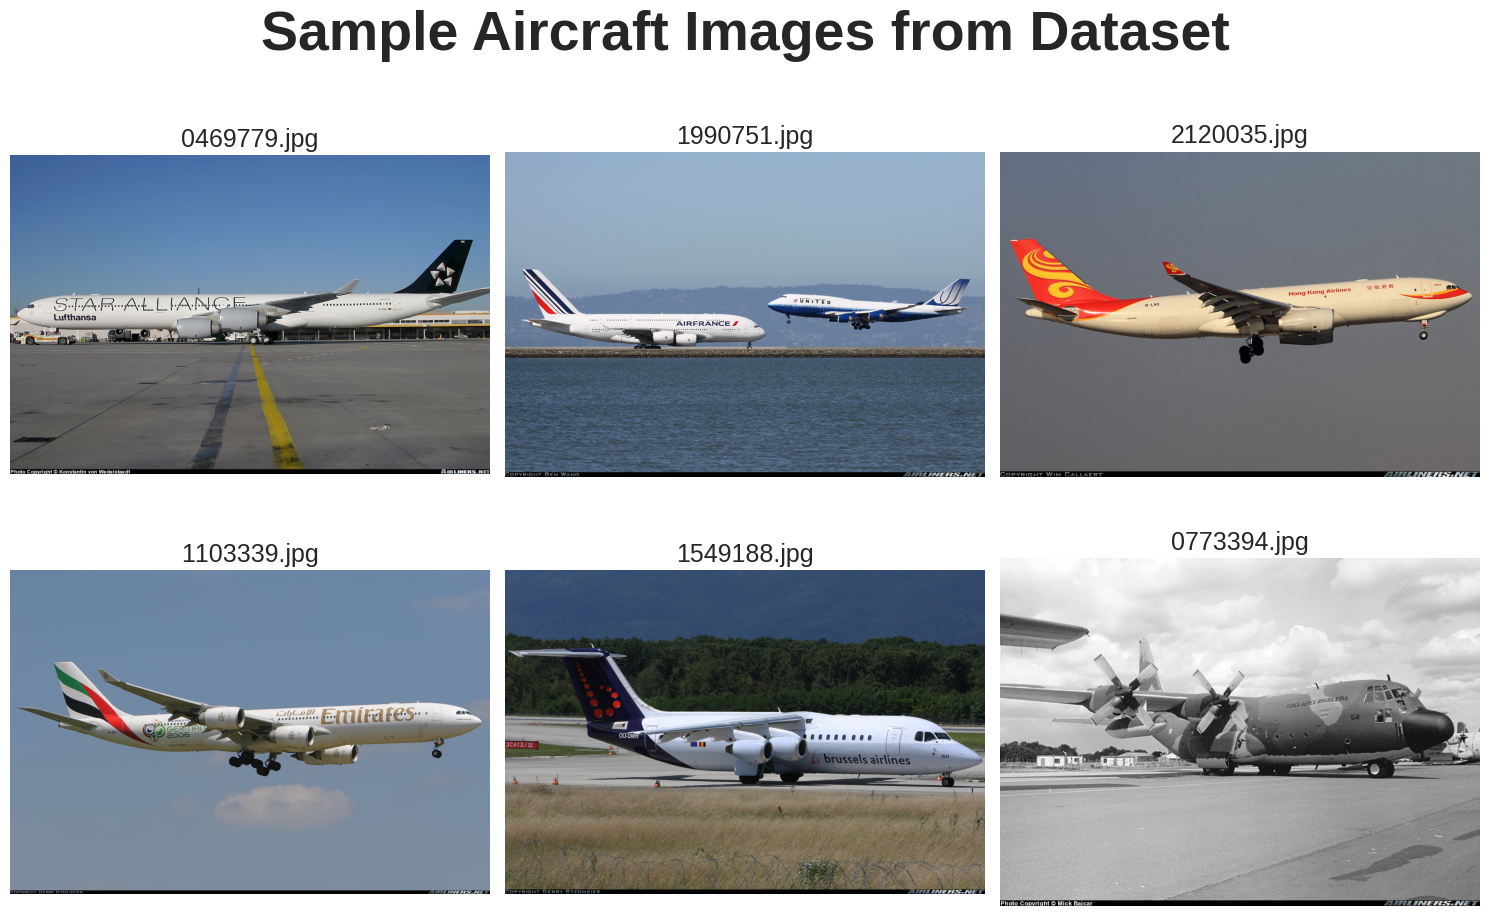

In [30]:
# Explore dataset structure
data_root = './fgvc-aircraft-2013b'

# Check if dataset exists
if os.path.exists(data_root):
    print("Dataset found!\n")

    # Count images
    images_dir = Path(data_root) / 'data' / 'images'
    image_count = len(list(images_dir.glob('*.jpg')))
    print(f"Total images: {image_count}")

    # Show sample images
    sample_images = list(images_dir.glob('*.jpg'))[:6]

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    for idx, img_path in enumerate(sample_images):
        img = Image.open(img_path)
        axes[idx].imshow(img)
        axes[idx].axis('off')
        axes[idx].set_title(img_path.name, fontsize=18)

    plt.suptitle('Sample Aircraft Images from Dataset', fontsize= 40, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print("Dataset not found. Please download and extract it first.")
    print("URL: https://www.robots.ox.ac.uk/~vgg/data/fgvc-aircraft/archives/fgvc-aircraft-2013b.tar.gz")

In [31]:
# Configuration
DATA_ROOT = './fgvc-aircraft-2013b'
VARIANT_LEVEL = 'family'  # Change to 'variant' or 'manufacturer' as needed
BATCH_SIZE = 32
NUM_EPOCHS = 5  # Start with 5 for testing, use 50+ for production
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"Configuration:")
print(f"  Level: {VARIANT_LEVEL}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Device: {DEVICE}")

Configuration:
  Level: family
  Batch size: 32
  Epochs: 5
  Device: cuda


In [37]:
# Initialize trainer
trainer = AircraftClassifierTrainer(
    data_root=DATA_ROOT,
    variant_level=VARIANT_LEVEL,
    batch_size=BATCH_SIZE,
    num_workers=2,  # Adjust based on your CPU
    device=DEVICE
)

print(f"\n  Trainer initialized")
print(f"  Aircraft classes: {len(trainer.train_dataset.unique_labels)}")
print(f"  Training samples: {len(trainer.train_dataset)}")
print(f"  Validation samples: {len(trainer.val_dataset)}")


  Trainer initialized
  Aircraft classes: 70
  Training samples: 3334
  Validation samples: 3333



Training Aircraft Classifier (family level)
Classes: 70
Train: 3334 | Val: 3333
Device: cuda

Epoch 1/5


Validation: 100%|██████████| 105/105 [00:39<00:00,  2.65it/s]


Train Loss: 4.1650, Acc: 4.35%
Val Loss: 3.6300, Acc: 15.33%

Saved best model (Val Acc: 15.33%)

Epoch 2/5


Validation: 100%|██████████| 105/105 [00:39<00:00,  2.67it/s]


Train Loss: 3.2577, Acc: 18.21%
Val Loss: 2.5841, Acc: 29.85%

Saved best model (Val Acc: 29.85%)

Epoch 3/5


Validation: 100%|██████████| 105/105 [00:39<00:00,  2.65it/s]


Train Loss: 2.2353, Acc: 33.17%
Val Loss: 1.8334, Acc: 48.75%

Saved best model (Val Acc: 48.75%)

Epoch 4/5


Validation: 100%|██████████| 105/105 [00:40<00:00,  2.61it/s]


Train Loss: 1.5865, Acc: 49.37%
Val Loss: 1.4201, Acc: 53.05%

Saved best model (Val Acc: 53.05%)

Epoch 5/5


Validation: 100%|██████████| 105/105 [00:40<00:00,  2.59it/s]


Train Loss: 1.1459, Acc: 60.05%
Val Loss: 1.3146, Acc: 59.47%

Saved best model (Val Acc: 59.47%)

Training complete! Best Val Acc: 59.47%


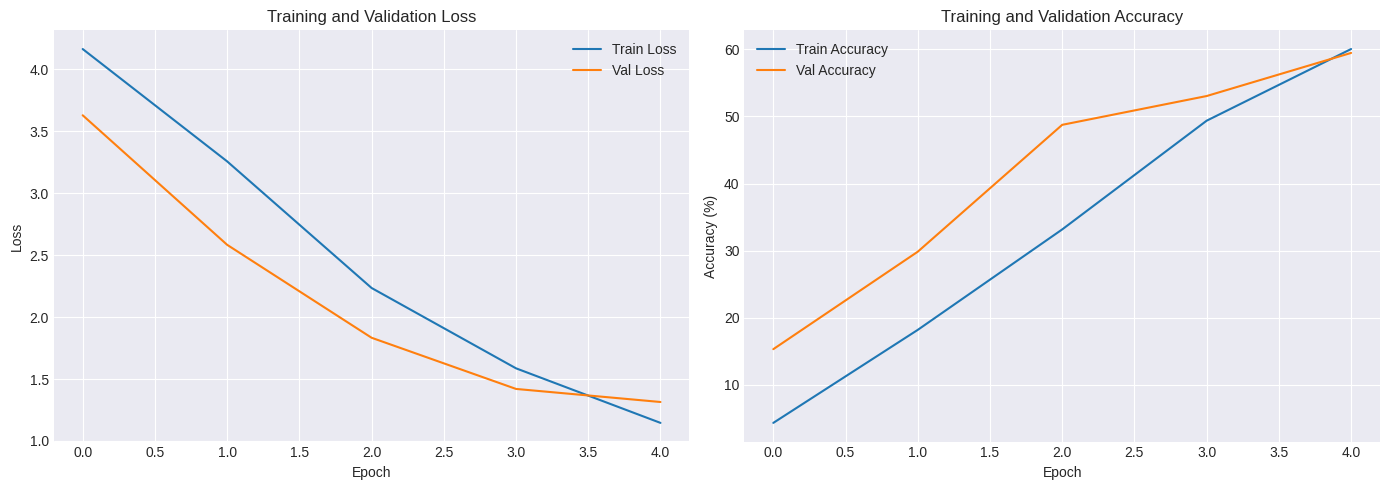

In [38]:
# Train the model
history = trainer.train(num_epochs=NUM_EPOCHS, save_dir='./checkpoints')
# Plot training history
trainer.plot_training_history()